# DoWhy ve EconML ile Koşullu Ortalama Tedavi Etkileri (CATE)

Bu, DoWhy'dan EconML yöntemlerini kullandığımız deneysel bir özelliktir. EconML kullanımı, farklı yöntemler kullanarak CATE tahminine olanak tanır.

DoWhy'daki nedensel çıkarımın dört adımı da aynı kalır: modelleme, tanımlama, tahmin etme ve çürütme. Temel fark, artık tahmin adımında econml yöntemlerini çağırmamızdır. CATE tahmin edicilerinin ardındaki sezgiyi anlamak için doğrusal regresyon kullanan daha basit bir örnek de vardır.

Tüm veri kümeleri doğrusal yapısal denklemler kullanılarak üretilir.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [2]:
data = dowhy.datasets.linear_dataset(
    beta=BETA,
    num_common_causes=4,
    num_samples=10000,
    num_instruments=2,
    num_effect_modifiers=2,
    num_treatments=1,
    treatment_is_binary=False,
    num_discrete_common_causes=2,
    num_discrete_effect_modifiers=0,
    one_hot_encode=False
)

df = data["df"]
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.699072  0.698454  0.0  0.125712  0.516288  1.088315  0  0   4.303028   
1  1.678298 -0.260666  0.0  0.022346  1.618177  1.997136  0  0   6.554417   
2 -0.005526 -0.748464  0.0  0.497814  0.692727  2.298905  0  2  11.335411   
3 -0.121529 -1.646760  1.0  0.224850  0.611446  1.150921  1  1  18.421385   
4 -0.930890 -0.508015  0.0  0.685642  1.968210 -0.404067  2  3  14.486515   

            y  
0   63.620422  
1   88.559736  
2   98.121973  
3   86.848848  
4  115.873260  
True causal estimate is 6.769173636927194


In [4]:
model = CausalModel(
    data=data['df'],
    treatment=data['treatment_name'],
    outcome=data['outcome_name'],
    graph=data['gml_graph']
)

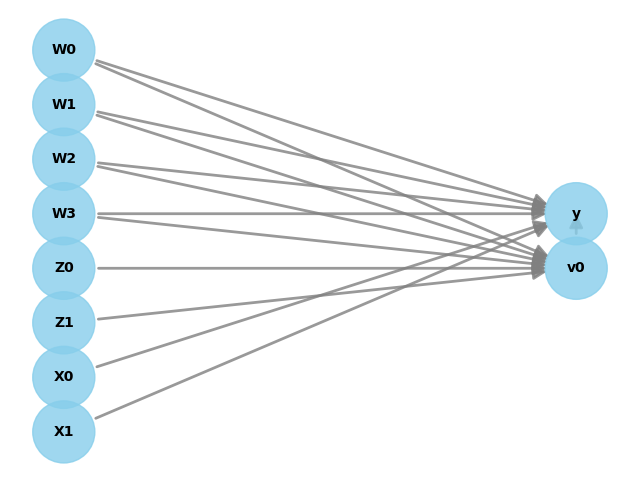

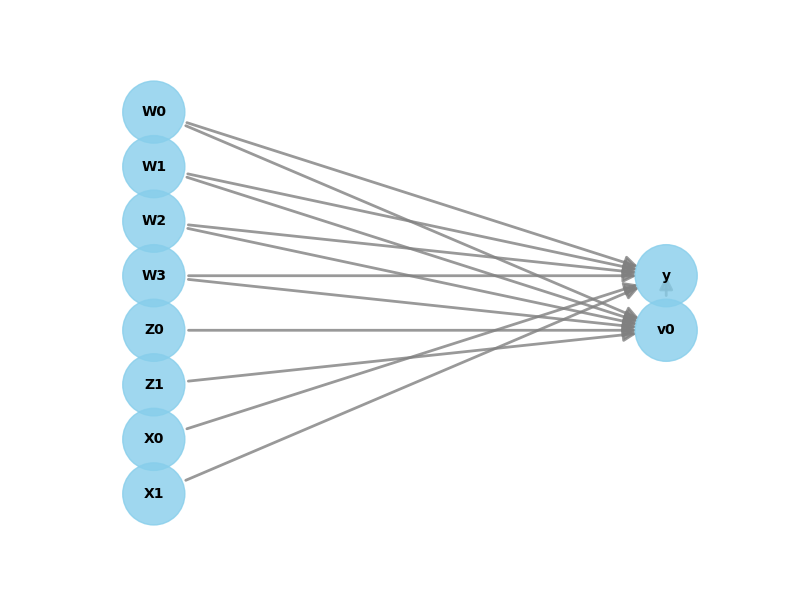

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# 1.Doğrusal Model

Öncelikle, CATE'yi tahmin etmek için doğrusal bir model kullanarak biraz sezgi oluşturalım. Etki değiştiricileri (effect modifiers) (heterojen bir tedavi etkisine yol açan) tedaviyle etkileşim terimleri olarak modellenebilir. Bu nedenle, değerleri tedavinin etkisini düzenler.

Tedaviyi 0'dan 1'e değiştirmenin tahmini etkisi aşağıdaki denklemle verilir:

In [7]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1
                                        )
print(linear_estimate)                                        

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1+v0*X1+v0*X0
Target units: 

## Estimate
Mean value: 6.76944345759741
### Conditional Estimates
__categorical__X1  __categorical__X0
(-4.711, -1.708]   (-4.304, -1.073]      0.214793
                   (-1.073, -0.459]      1.295883
                   (-0.459, 0.0395]      1.898047
                   (0.0395, 0.657]       2.604803
                   (0.657, 3.023]        3.794229
(-1.708, -1.127]   (-4.304, -1.073]      3.215591
                   (-1.073, -0.459]      4.274182
                   (-0.459, 0.0395]      4.959988
                   (0.0395, 0.657]       5.578305
                   (0.657, 3.023]      

# 2.EconML Yöntemleri

Şimdi CATE tahmini için EconML paketinden daha gelişmiş yöntemlere geçiyoruz.

İlk olarak, çift yapay öğrenme tahmin edicisine (double machine learning) bakalım. Method_name, kullanmak istediğimiz sınıfın tam nitelikli adına karşılık gelir. Çift ML için bu, "econml.dml.DML"dir.

Hedef birimler, nedensel tahminin hesaplanacağı birimleri tanımlar. Bu, orijinal veri çerçevesindeki bir lambda fonksiyonu filtresi, yeni bir Pandas veri çerçevesi veya üç ana hedef birimi türüne ("ate", "att" ve "atc") karşılık gelen bir dize olabilir. Aşağıda bir lambda fonksiyonuna örnek gösteriyoruz.

Method_params doğrudan EconML'ye geçirilir. İzin verilen parametreler hakkında ayrıntılı bilgi için EconML belgelerine bakın.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                     target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 8.692720171314297
Effect estimates: [[11.03479279]
 [10.91448281]
 [ 5.44564929]
 ...
 [10.41821058]
 [ 7.91672012]
 [ 9.61764938]]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 6.769173636927194


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                     target_units = 1,  # condition used for CATE
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: 

## Estimate
Mean value: 6.71152873491397
Effect estimates: [[13.08018328]
 [10.98645726]
 [ 7.36350466]
 ...
 [ 8.74444364]
 [ 3.76050815]
 [ 9.86098408]]



# 3.CATE Nesnesi ve Güven Aralıkları

EconML, güven aralıklarını hesaplamak için kendi yöntemlerini sunar. Aşağıdaki örnekte BootstrapInference'ı kullanmaya bakacağız:

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)

## Realized estimand
b: y~v0+W3+W0+W2+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 6.72430928020749
Effect estimates: [[13.1122209 ]
 [10.99452933]
 [ 7.3766931 ]
 ...
 [ 8.77810936]
 [ 3.7876019 ]
 [ 9.89741817]]
95.0% confidence interval: [[[13.18479252 10.99575921  7.39973944 ...  8.83438366  3.74565686
    9.95885409]]

 [[13.46782263 11.24615838  7.50370793 ...  9.01670568  3.93396764
   10.17677641]]]



***Hedef birimler olarak yeni girdiler sağlanabilir ve bunlar üzerinde CATE tahmini yapılabilir.***

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[10.79351534]
 [13.07881023]
 [11.98342576]
 [12.82090552]
 [11.88497859]
 [12.10311463]
 [13.72663527]
 [11.61275955]
 [13.52180186]
 [13.58312412]]


***Ayrıca, herhangi bir sonraki işlem için ham EconML tahmin nesnesini de alabilirsiniz***

In [13]:
print(dml_estimate._estimator_object)

# 4.Herhangi bir EconML Yöntemiyle Çalışma